In [4]:
%matplotlib inline

In [5]:
import datetime
import numpy as np 
import pandas as pd 
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt
import prettyplotlib as ppl
import brewer2mpl
import random
from operator import itemgetter
import time
import copy

In [6]:
set2 = brewer2mpl.get_map('Set2', 'qualitative', 8).mpl_colors

font = {'family' : 'serif',
        'color'  : 'darkred',
        'weight' : 'bold',
        'size'   : 16,
        }
plt.rc('font',family='serif')
plt.rc('font', size=16)
plt.rc('font', weight='bold')
plt.style.use('fivethirtyeight')
    
# Get current size
fig_size = plt.rcParams["figure.figsize"]
 
# Set figure width to 6 and height to 6
fig_size[0] = 6
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

### Load Data

In [7]:
train = pd.read_csv('data/act_train.csv', dtype={'people_id': np.str,
                               'activity_id': np.str,
                               'outcome': np.int8}, parse_dates=['date'])
test = pd.read_csv('data/act_test.csv', dtype={'people_id': np.str,
                              'activity_id': np.str}, parse_dates=['date'])
people = pd.read_csv('data/people.csv', dtype={'people_id': np.str,
                              'activity_id': np.str,
                              'char_38': np.int32},parse_dates=['date'])
df_train = pd.merge(train, people, on='people_id')
df_test = pd.merge(test, people, on='people_id')

In [8]:
train.head()

people_id   activity_id       date activity_category char_1 char_2 char_3  \
0   ppl_100  act2_1734928 2023-08-26            type 4    NaN    NaN    NaN   
1   ppl_100  act2_2434093 2022-09-27            type 2    NaN    NaN    NaN   
2   ppl_100  act2_3404049 2022-09-27            type 2    NaN    NaN    NaN   
3   ppl_100  act2_3651215 2023-08-04            type 2    NaN    NaN    NaN   
4   ppl_100  act2_4109017 2023-08-26            type 2    NaN    NaN    NaN   

  char_4 char_5 char_6 char_7 char_8 char_9  char_10  outcome  
0    NaN    NaN    NaN    NaN    NaN    NaN  type 76        0  
1    NaN    NaN    NaN    NaN    NaN    NaN   type 1        0  
2    NaN    NaN    NaN    NaN    NaN    NaN   type 1        0  
3    NaN    NaN    NaN    NaN    NaN    NaN   type 1        0  
4    NaN    NaN    NaN    NaN    NaN    NaN   type 1        0

In [7]:
test.head()

people_id   activity_id       date activity_category   char_1   char_2  \
0  ppl_100004   act1_249281 2022-07-20            type 1   type 5  type 10   
1  ppl_100004   act2_230855 2022-07-20            type 5      NaN      NaN   
2   ppl_10001   act1_240724 2022-10-14            type 1  type 12   type 1   
3   ppl_10001    act1_83552 2022-11-27            type 1  type 20  type 10   
4   ppl_10001  act2_1043301 2022-10-15            type 5      NaN      NaN   

   char_3  char_4  char_5  char_6  char_7   char_8   char_9    char_10  
0  type 5  type 1  type 6  type 1  type 1   type 7   type 4        NaN  
1     NaN     NaN     NaN     NaN     NaN      NaN      NaN   type 682  
2  type 5  type 4  type 6  type 1  type 1  type 13  type 10        NaN  
3  type 5  type 4  type 6  type 1  type 1   type 5   type 5        NaN  
4     NaN     NaN     NaN     NaN     NaN      NaN      NaN  type 3015

In [8]:
people.head()

people_id  char_1      group_1  char_2       date   char_3   char_4  \
0     ppl_100  type 2  group 17304  type 2 2021-06-29   type 5   type 5   
1  ppl_100002  type 2   group 8688  type 3 2021-01-06  type 28   type 9   
2  ppl_100003  type 2  group 33592  type 3 2022-06-10   type 4   type 8   
3  ppl_100004  type 2  group 22593  type 3 2022-07-20  type 40  type 25   
4  ppl_100006  type 2   group 6534  type 3 2022-07-27  type 40  type 25   

   char_5  char_6   char_7   ...   char_29 char_30 char_31 char_32 char_33  \
0  type 5  type 3  type 11   ...     False    True    True   False   False   
1  type 5  type 3  type 11   ...     False    True    True    True    True   
2  type 5  type 2   type 5   ...     False   False    True    True    True   
3  type 9  type 4  type 16   ...      True    True    True    True    True   
4  type 9  type 3   type 8   ...     False   False    True   False   False   

  char_34 char_35 char_36 char_37 char_38  
0    True    True    True   False      36  
1    True    True    True   False      76  
2    True   False    True    True      99  
3    True    True    True    True      76  
4   False    True    True   False      84  

[5 rows x 41 columns]

In [9]:
print("Process tables...")
for table in [train, test]:
        table['year'] = table['date'].dt.year
        table['month'] = table['date'].dt.month
        table['day'] = table['date'].dt.day
        table['day_of_week'] = table['date'].dt.dayofweek
        #table.drop('date', axis=1, inplace=True)
        table['activity_category'] = table['activity_category'].str.lstrip('type ').astype(np.int32)
        for i in range(1, 11):
            table['char_' + str(i)].fillna('type -999', inplace=True)
            table['char_' + str(i)] = table['char_' + str(i)].str.lstrip('type ').astype(np.int32)
people['year'] = people['date'].dt.year
people['month'] = people['date'].dt.month
people['day'] = people['date'].dt.day
people['day_of_week_people'] = people['date'].dt.dayofweek
#people.drop('date', axis=1, inplace=True)
people['group_1'] = people['group_1'].str.lstrip('group ').astype(np.int32)
for i in range(1, 10):
        people['char_' + str(i)] = people['char_' + str(i)].str.lstrip('type ').astype(np.int32)
for i in range(10, 38):
        people['char_' + str(i)] = people['char_' + str(i)].astype(np.int32)

print("Merge...")
train = pd.merge(train, people, how='left', on='people_id', left_index=True)
train.fillna(-999, inplace=True)
test = pd.merge(test, people, how='left', on='people_id', left_index=True)
test.fillna(-999, inplace=True)

Process tables...
Merge...


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2197291 entries, 0 to 189116
Data columns (total 63 columns):
people_id             object
activity_id           object
date_x                datetime64[ns]
activity_category     int32
char_1_x              int32
char_2_x              int32
char_3_x              int32
char_4_x              int32
char_5_x              int32
char_6_x              int32
char_7_x              int32
char_8_x              int32
char_9_x              int32
char_10_x             int32
outcome               int8
year_x                int64
month_x               int64
day_x                 int64
day_of_week           int64
char_1_y              int32
group_1               int32
char_2_y              int32
date_y                datetime64[ns]
char_3_y              int32
char_4_y              int32
char_5_y              int32
char_6_y              int32
char_7_y              int32
char_8_y              int32
char_9_y              int32
char_10_y             int32
c

### Outcome Field 

In [10]:
plus = sum(train.loc[:, 'outcome'] == 0)
minus = sum(train.loc[:, 'outcome'] == 1)

print (plus, minus)
print (df_train['outcome'].unique())

1221794 975497
[0 1]


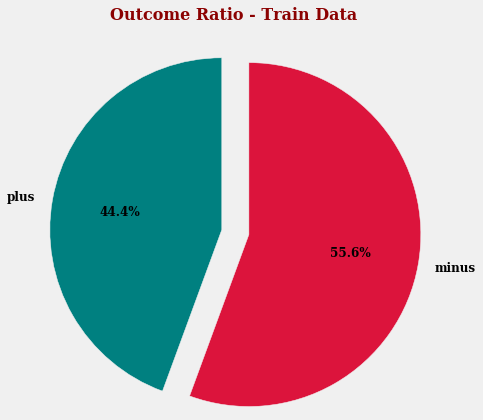

In [12]:
from matplotlib import rcParams
rcParams['font.size'] = 12
#print (rcParams.keys())
rcParams['text.color'] = 'black'

piechart = plt.pie(
    (minus, plus),
    labels=('plus', 'minus'),
    shadow=False,
    colors=('teal', 'crimson'),
    explode=(0.08,0.08), # space between slices 
    startangle=90,    # rotate conter-clockwise by 90 degrees
    autopct='%1.1f%%',# display fraction as percentages
)

plt.axis('equal')   
plt.title("Outcome Ratio - Train Data", y=1.08,fontdict=font)
plt.tight_layout()
plt.show()

### Date Field 

In [11]:
for d in ['date_x', 'date_y']:
    print('Start of ' + d + ': ' + str(train[d].min().date()))
    print('  End of ' + d + ': ' + str(train[d].max().date()))
    print('Range of ' + d + ': ' + str(train[d].max() - train[d].min()) + '\n')

Start of date_x: 2022-07-17
  End of date_x: 2023-08-31
Range of date_x: 410 days 00:00:00

Start of date_y: 2020-05-18
  End of date_y: 2023-08-31
Range of date_y: 1200 days 00:00:00



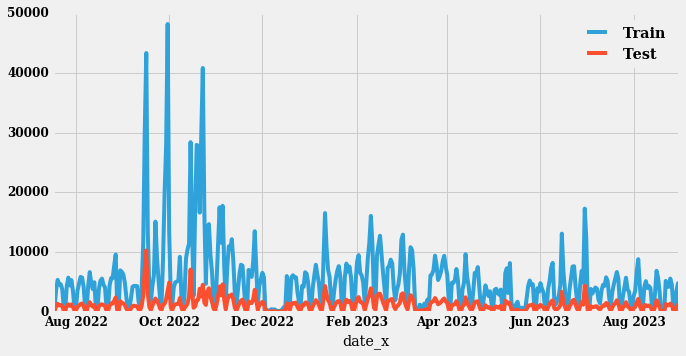

In [15]:
train['date_x'].groupby(train.date_x.dt.date).count().plot(figsize=(10,5), label='Train')
test['date_x'].groupby(test.date_x.dt.date).count().plot(figsize=(10,5), label='Test')
plt.legend()
plt.show()

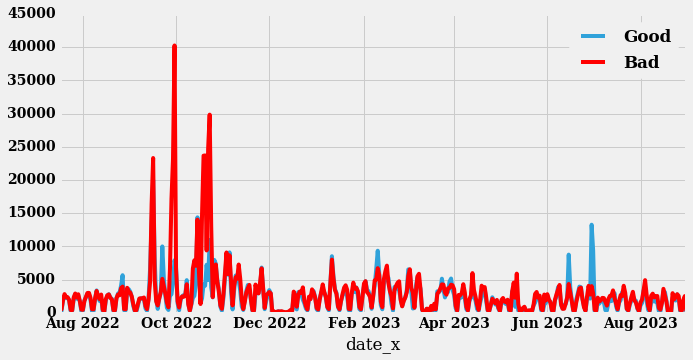

In [10]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]

goods['date_x'].groupby(goods.date_x.dt.date).count().plot(figsize=(10,5),label='Good')
bads['date_x'].groupby(bads.date_x.dt.date).count().plot(figsize=(10,5),c='r',label='Bad')
plt.legend()
plt.show()

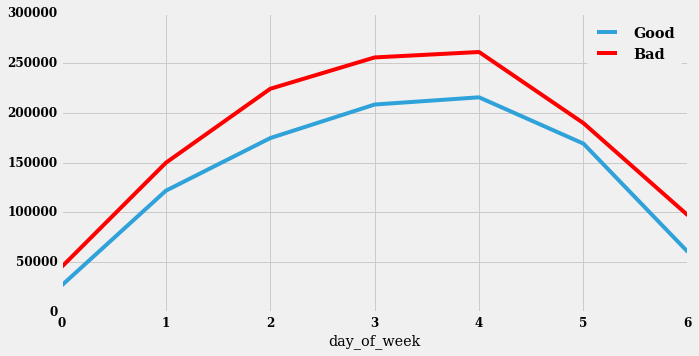

In [17]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]

goods['day_of_week'].groupby(goods.day_of_week).count().plot(figsize=(10,5),label='Good')
bads['day_of_week'].groupby(bads.day_of_week).count().plot(figsize=(10,5),c='r',label='Bad')
plt.legend()
plt.show()

### Unique People 

In [12]:
nTotalUnq = len(people['people_id'].unique())
# Total people present in Training set
peopleTrain = train['people_id'].unique()
nTrainUnq = len(peopleTrain)

print('In total there are', nTotalUnq, 'people, of which', 
      nTrainUnq, '(', round(nTrainUnq/nTotalUnq*100), '%) are present in the training set.')

In total there are 189118 people, of which 151295 ( 80 %) are present in the training set.


In [13]:
# Total people present in test set
peopleTest = test['people_id'].unique()
nTestUnq = len(peopleTest)

print('In total there are', nTotalUnq, 'people, of which', 
      nTestUnq, '(', round(nTestUnq/nTotalUnq*100), '%) are present in the test set.')

In total there are 189118 people, of which 37823 ( 20 %) are present in the test set.


### Activity Type vs. Characteristics

In [20]:
train['activity_category'].describe()

count    2.197291e+06
mean     2.997433e+00
std      1.314097e+00
min      1.000000e+00
25%      2.000000e+00
50%      3.000000e+00
75%      4.000000e+00
max      7.000000e+00
Name: activity_category, dtype: float64

In [14]:
columns = train.columns
print(columns)

Index(['people_id', 'activity_id', 'date_x', 'activity_category', 'char_1_x',
       'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x',
       'char_8_x', 'char_9_x', 'char_10_x', 'outcome', 'year_x', 'month_x',
       'day_x', 'day_of_week', 'char_1_y', 'group_1', 'char_2_y', 'date_y',
       'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y',
       'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'year_y', 'month_y', 'day_y', 'day_of_week_people'],
      dtype='object')


In [15]:
characteristics = [x for x in columns if x.find('char_')!= -1]
print(characteristics)

['char_1_x', 'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x', 'char_8_x', 'char_9_x', 'char_10_x', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38']


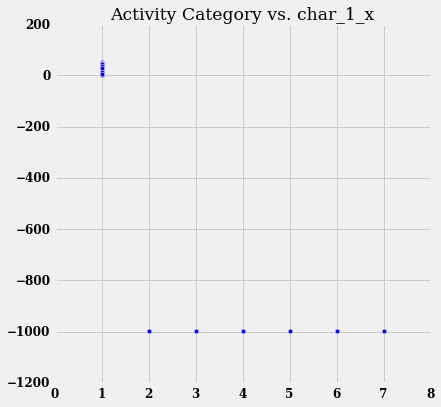

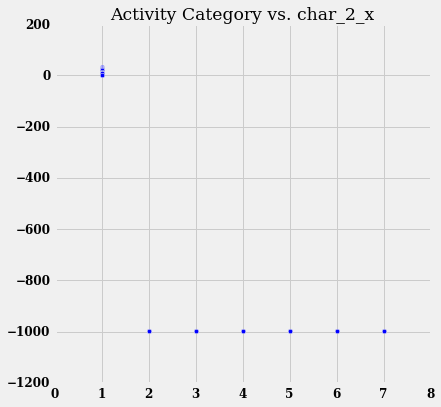

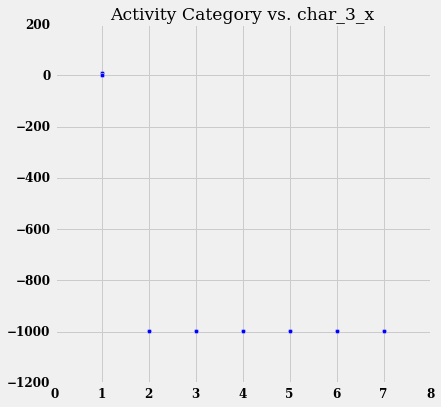

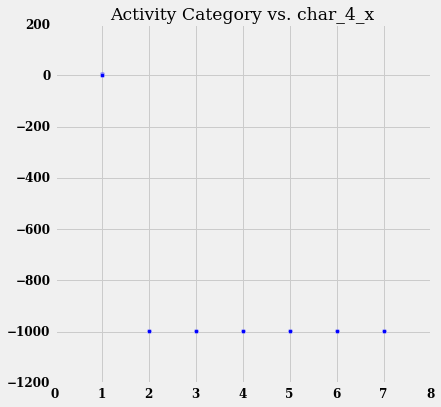

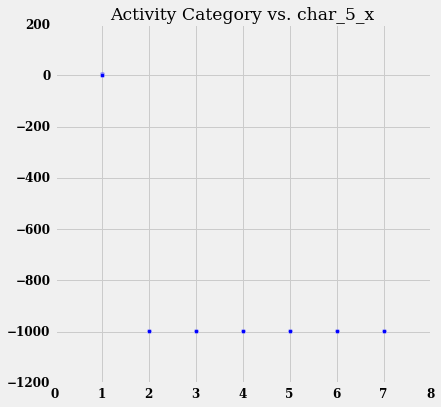

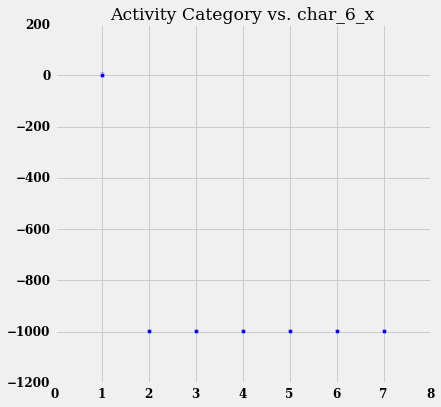

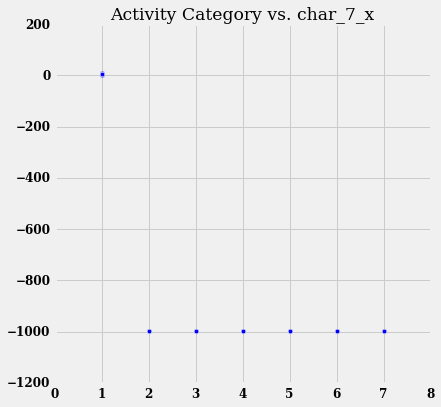

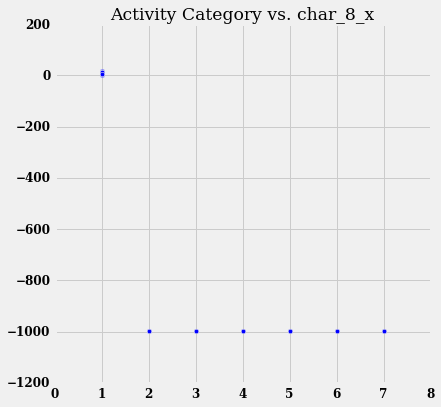

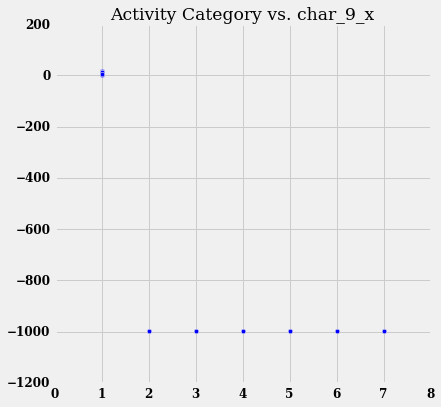

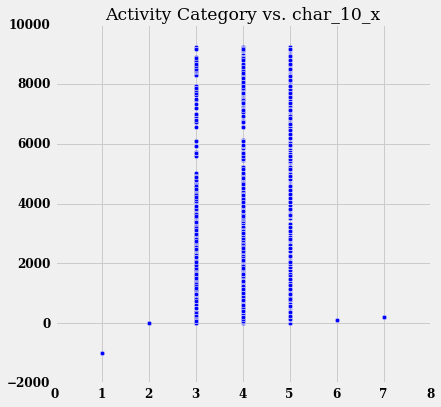

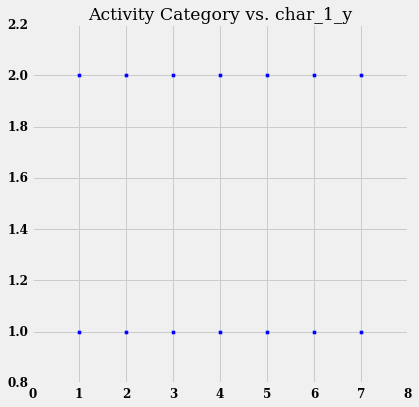

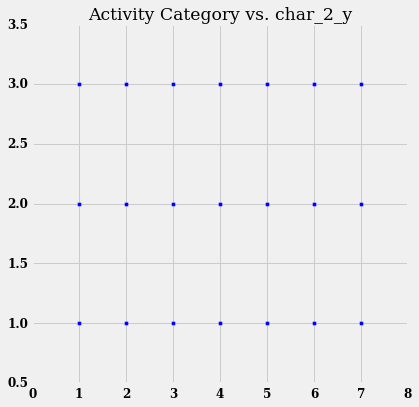

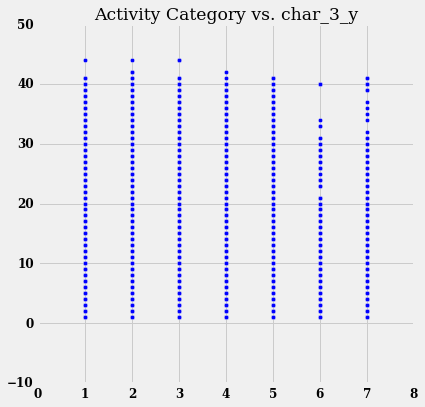

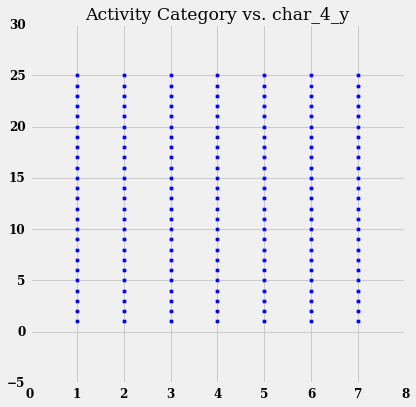

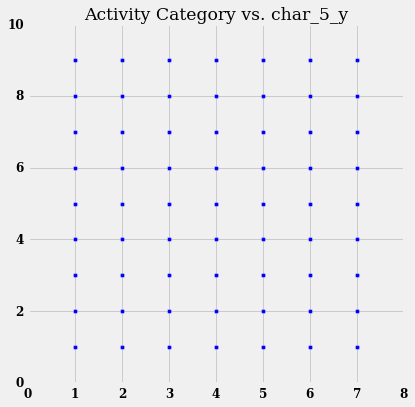

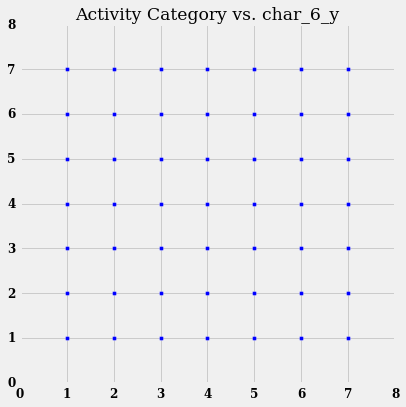

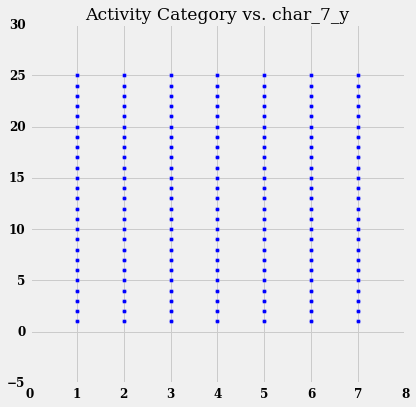

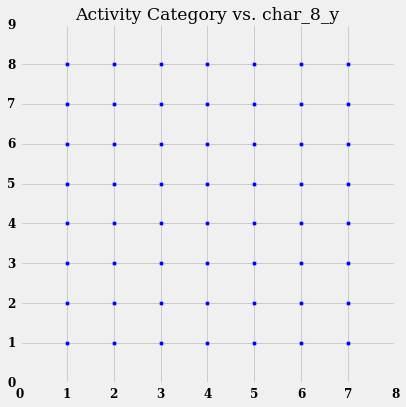

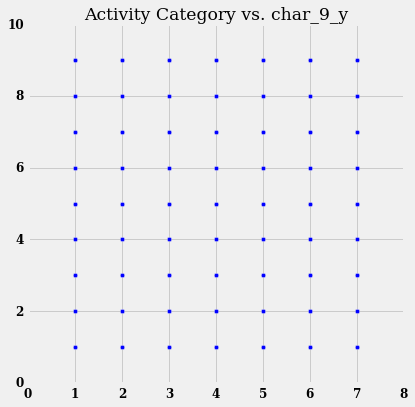

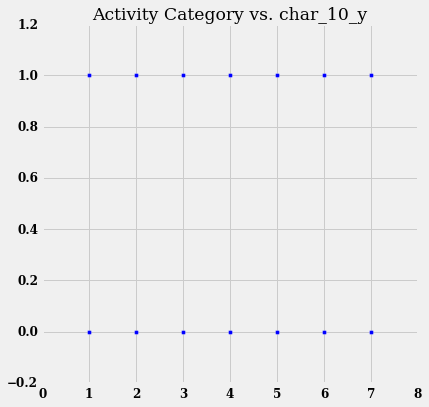

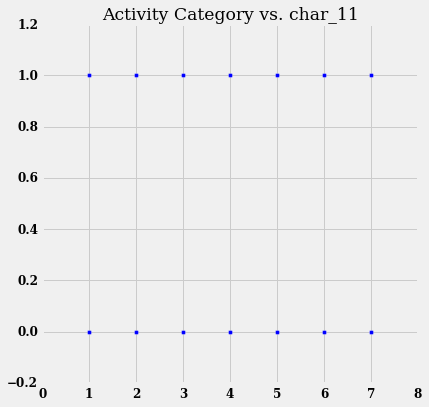

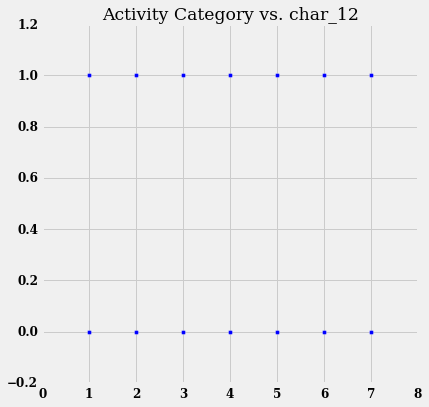

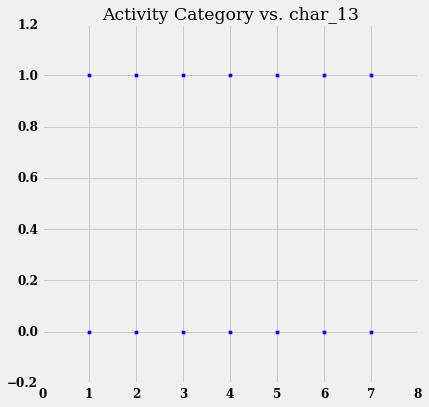

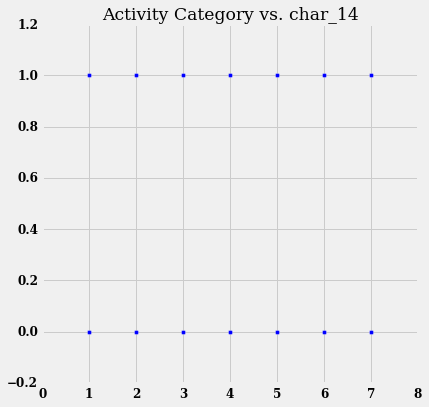

KeyboardInterrupt: 

In [23]:
for i in characteristics:
    plt.scatter(train['activity_category'], train[i])
    plt.title("Activity Category vs. " + i)
    plt.show()

- Only Activity Type 1 is correlated with Char_1_x to Char_9_x
- Char_10_x seems to be useless for Activity Type 1
- Char_1_y to Char_10_y seems active for all Activity Types
- Char_11 to Char_37 seems active for all Activity Types

### Outcome vs. Activity Type

In [ ]:
plt.scatter(train['outcome'], train['activity_category'])
plt.title("Outcome vs Activity Category")
plt.show()

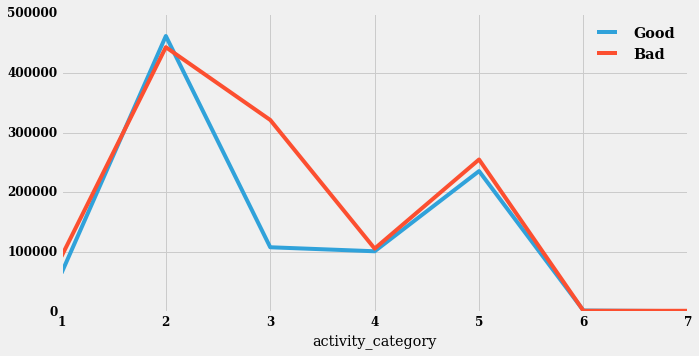

In [25]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]
goods['activity_category'].groupby(goods.activity_category).count().plot(figsize=(10,5),label='Good')
bads['activity_category'].groupby(bads.activity_category).count().plot(figsize=(10,5),label='Bad')
plt.legend()
plt.show()

- Activity Type 3 looks like leads to lot of bad outcomes!
- Activity Type 2 seems to slightly biased towards good outcome 
- Activity Type 5 seems to slightly biased towards bad outcome
- Activity Type 6 & 7 seem to be very rare

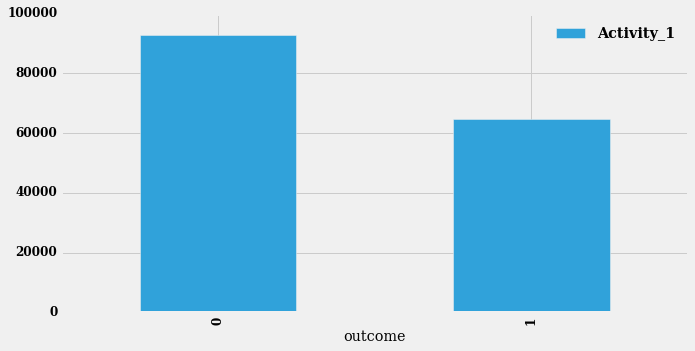

In [26]:
ac1=train[train['activity_category']==1]
ac1['outcome'].groupby(ac1.outcome).count().plot(figsize=(10,5),label='Activity_1', kind='bar')
plt.legend()
plt.show()

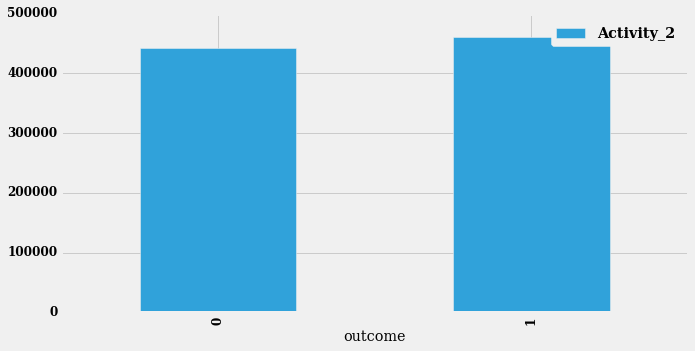

In [27]:
ac2=train[train['activity_category']==2]
ac2['outcome'].groupby(ac2.outcome).count().plot(figsize=(10,5),label='Activity_2', kind='bar')
plt.legend()
plt.show()

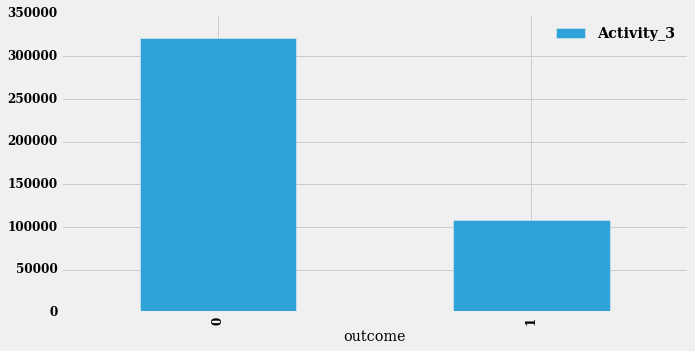

In [ ]:
ac3=train[train['activity_category']==3]
ac3['outcome'].groupby(ac3.outcome).count().plot(figsize=(10,5),label='Activity_3', kind='bar')
plt.legend()
plt.show()

In [ ]:
ac4=train[train['activity_category']==4]
ac4['outcome'].groupby(ac4.outcome).count().plot(figsize=(10,5),label='Activity_4', kind='bar')
plt.legend()
plt.show()

In [ ]:
ac5=train[train['activity_category']==5]
ac5['outcome'].groupby(ac5.outcome).count().plot(figsize=(10,5),label='Activity_5', kind='bar')
plt.legend()
plt.show()

In [ ]:
ac5=train[train['activity_category']==5]
ac5['outcome'].groupby(ac5.outcome).count().plot(figsize=(10,5),label='Activity_5', kind='bar')
plt.legend()
plt.show()

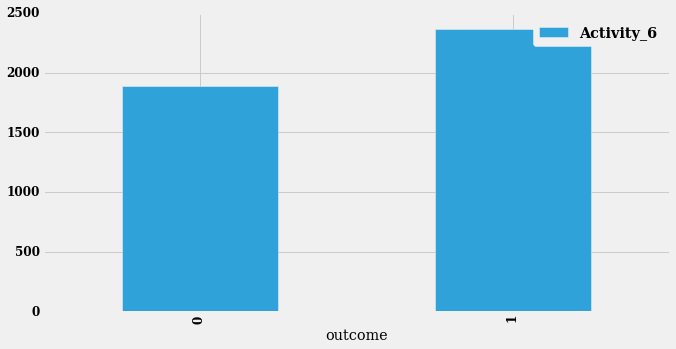

In [30]:
ac6=train[train['activity_category']==6]
ac6['outcome'].groupby(ac6.outcome).count().plot(figsize=(10,5),label='Activity_6', kind='bar')
plt.legend()
plt.show()

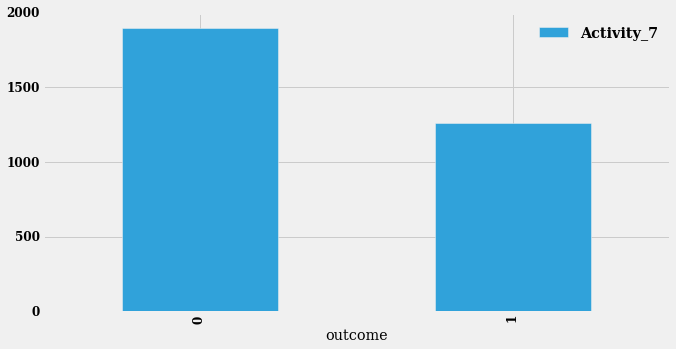

In [31]:
ac7=train[train['activity_category']==7]
ac7['outcome'].groupby(ac7.outcome).count().plot(figsize=(10,5),label='Activity_7', kind='bar')
plt.legend()
plt.show()

### Group vs. Outcome

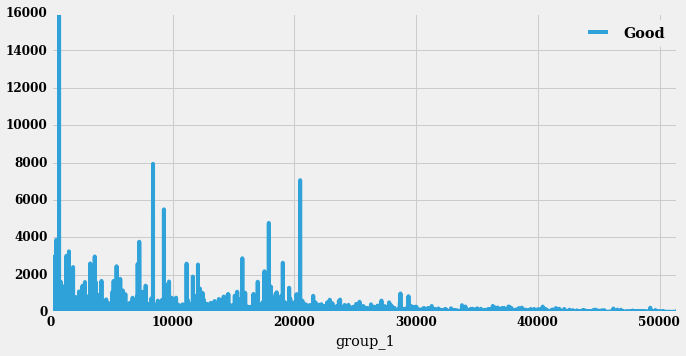

In [32]:
goods=train[train['outcome']==1]
bads=train[train['outcome']==0]
goods['group_1'].groupby(goods.group_1).count().plot(figsize=(10,5),label='Good')
#bads['group_1'].groupby(bads.group_1).count().plot(figsize=(10,5),label='Bad')
plt.legend()
plt.show()

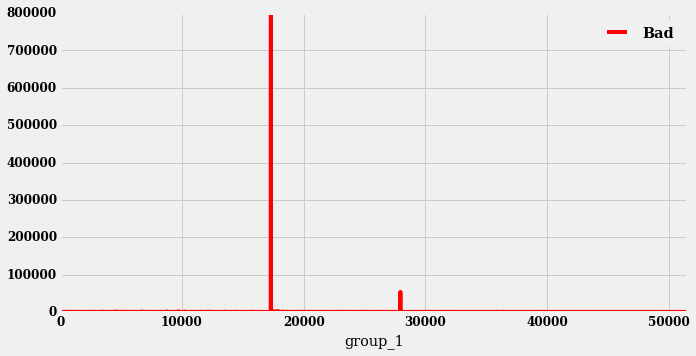

In [33]:
bads=train[train['outcome']==0]
bads['group_1'].groupby(bads.group_1).count().plot(figsize=(10,5),label='Bad', color='red')
plt.legend()
plt.show()

- group1 value around 16205 has a huge number of bads - close to 80000 rows !!
- group1 value of 0 has mostly good

In [34]:
train.group_1.describe()

count    2197291.000000
mean       16205.907166
std         9785.620798
min            1.000000
25%         9107.000000
50%        17304.000000
75%        18528.000000
max        51462.000000
Name: group_1, dtype: float64

### Common People in Train and Test

In [15]:
print(people.columns)

Index(['people_id', 'char_1', 'group_1', 'char_2', 'date', 'char_3', 'char_4',
       'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38', 'year', 'month', 'day',
       'day_of_week_people'],
      dtype='object')


In [16]:
people_columns = ['char_1', 'group_1', 'char_2', 'date', 'char_3', 'char_4',
       'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38']

In [17]:
print(train.columns)

Index(['people_id', 'activity_id', 'date_x', 'activity_category', 'char_1_x',
       'char_2_x', 'char_3_x', 'char_4_x', 'char_5_x', 'char_6_x', 'char_7_x',
       'char_8_x', 'char_9_x', 'char_10_x', 'outcome', 'year_x', 'month_x',
       'day_x', 'day_of_week', 'char_1_y', 'group_1', 'char_2_y', 'date_y',
       'char_3_y', 'char_4_y', 'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y',
       'char_9_y', 'char_10_y', 'char_11', 'char_12', 'char_13', 'char_14',
       'char_15', 'char_16', 'char_17', 'char_18', 'char_19', 'char_20',
       'char_21', 'char_22', 'char_23', 'char_24', 'char_25', 'char_26',
       'char_27', 'char_28', 'char_29', 'char_30', 'char_31', 'char_32',
       'char_33', 'char_34', 'char_35', 'char_36', 'char_37', 'char_38',
       'year_y', 'month_y', 'day_y', 'day_of_week_people'],
      dtype='object')


### Get Unique People from Train

In [19]:
people_train = train[['people_id', 'char_1_y', 'group_1', 'char_2_y', 'char_3_y', 'char_4_y',
       'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38']]
people_train.drop_duplicates(inplace=True)

C:\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [20]:
people_train.count()

people_id    151295
char_1_y     151295
group_1      151295
char_2_y     151295
char_3_y     151295
char_4_y     151295
char_5_y     151295
char_6_y     151295
char_7_y     151295
char_8_y     151295
char_9_y     151295
char_10_y    151295
char_11      151295
char_12      151295
char_13      151295
char_14      151295
char_15      151295
char_16      151295
char_17      151295
char_18      151295
char_19      151295
char_20      151295
char_21      151295
char_22      151295
char_23      151295
char_24      151295
char_25      151295
char_26      151295
char_27      151295
char_28      151295
char_29      151295
char_30      151295
char_31      151295
char_32      151295
char_33      151295
char_34      151295
char_35      151295
char_36      151295
char_37      151295
char_38      151295
dtype: int64

### Get Unique People from Test

In [21]:
people_test = test[['people_id', 'char_1_y', 'group_1', 'char_2_y', 'char_3_y', 'char_4_y',
       'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38']]
people_test.drop_duplicates(inplace=True)

C:\Anaconda3\lib\site-packages\pandas\util\decorators.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return func(*args, **kwargs)


In [22]:
people_test.count()

people_id    37823
char_1_y     37823
group_1      37823
char_2_y     37823
char_3_y     37823
char_4_y     37823
char_5_y     37823
char_6_y     37823
char_7_y     37823
char_8_y     37823
char_9_y     37823
char_10_y    37823
char_11      37823
char_12      37823
char_13      37823
char_14      37823
char_15      37823
char_16      37823
char_17      37823
char_18      37823
char_19      37823
char_20      37823
char_21      37823
char_22      37823
char_23      37823
char_24      37823
char_25      37823
char_26      37823
char_27      37823
char_28      37823
char_29      37823
char_30      37823
char_31      37823
char_32      37823
char_33      37823
char_34      37823
char_35      37823
char_36      37823
char_37      37823
char_38      37823
dtype: int64

In [23]:
common_people = pd.merge(people_train, people_test, how='inner', 
                         on=['group_1', 'char_1_y', 'char_2_y', 'char_3_y', 'char_4_y',
       'char_5_y', 'char_6_y', 'char_7_y', 'char_8_y', 'char_9_y', 'char_10_y', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38'],
                         left_index=True)
common_people.drop_duplicates(inplace=True)
common_people = common_people[['people_id_x', 'people_id_y']]

In [24]:
common_people.head()

people_id_x people_id_y
114290  ppl_100019  ppl_316653
114290  ppl_375848  ppl_316653
140     ppl_100028  ppl_100263
464     ppl_100028  ppl_100837
468     ppl_100028  ppl_100844

In [46]:
import pickle 

with open('common_people.pickle', 'wb') as handle:
    pickle.dump(common_people, handle)
    
common_people.describe()

people_id_x people_id_y
count      3663975     3663975
unique       52729       17661
top     ppl_134009    ppl_7444
freq           519        2069

### Get Total Goods and Bads Per Person in Train

In [26]:
good_counts=pd.DataFrame({'good_counts' : train[train['outcome']==1].groupby('people_id',as_index=True).size()}).reset_index()
bad_counts=pd.DataFrame({'bad_counts' : train[train['outcome']==0].groupby('people_id',as_index=True).size()}).reset_index()
history=good_counts.merge(bad_counts, on='people_id',how='left')
history['good_counts']=history['good_counts'].fillna('0').astype(np.int64)
history['bad_counts']=history['bad_counts'].fillna('0').astype(np.int64)
history['difference']=history['good_counts'] - history['bad_counts']

In [27]:
history.head()

people_id  good_counts  bad_counts  difference
0  ppl_100002            2           0           2
1  ppl_100003           34           0          34
2  ppl_100006            3           0           3
3  ppl_100013            5           0           5
4  ppl_100019            2           0           2

In [28]:
history.sort(columns ='good_counts', ascending=False).head(10)

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


people_id  good_counts  bad_counts  difference
62042   ppl_64887         7051           1        7050
68274   ppl_97427         1487           0        1487
61144   ppl_60206          736           0         736
67693    ppl_9442          730           0         730
49900  ppl_359707          556           0         556
51171  ppl_366313          555           0         555
530    ppl_102941          524           0         524
48447  ppl_352378          501           0         501
23505   ppl_22266          452           0         452
44764  ppl_333492          438         104         334

In [29]:
with open('history.pickle', 'wb') as handle:
    pickle.dump(history, handle)

1. For all the people in history.pickle (which are train set people) , join them to people data frame with the corresponding difference column in history

2. Now people_y column in common people are test people and people_x column is the train people they are related to (have exactly similar characteristics) .

3. Get the person in person_y find corresponding people_x person(s) and get the corresponding difference for that people_x from history and average the difference

4. so a new data frame from step 3 will have people_y and difference (which they inherited because of their relationship from people_x)

5. Use this new data frame to populate rest of the people in people data frame (from step1) . this is trickiest part since i don't know how to do it in one line - might need a loop

6. there would be still many in people data frame with NaN values for difference column , thats ok

7. Pickle the data frame and push it in git

In [30]:
# Step 1:  For all the people in history.pickle (which are train set people) , join them to people data frame with 
# the corresponding difference column in history
people_hist = people.merge(history, on='people_id',how='left')
print(people_hist.columns)

Index(['people_id', 'char_1', 'group_1', 'char_2', 'date', 'char_3', 'char_4',
       'char_5', 'char_6', 'char_7', 'char_8', 'char_9', 'char_10', 'char_11',
       'char_12', 'char_13', 'char_14', 'char_15', 'char_16', 'char_17',
       'char_18', 'char_19', 'char_20', 'char_21', 'char_22', 'char_23',
       'char_24', 'char_25', 'char_26', 'char_27', 'char_28', 'char_29',
       'char_30', 'char_31', 'char_32', 'char_33', 'char_34', 'char_35',
       'char_36', 'char_37', 'char_38', 'year', 'month', 'day',
       'day_of_week_people', 'good_counts', 'bad_counts', 'difference'],
      dtype='object')


In [31]:
#history.groupby('people_id').size()

In [50]:
#Step 2: Now people_y column in common people are test people and people_x column is the train people they are 
# related to (have exactly similar characteristics) .
# Step 3: Get the person in person_y find corresponding people_x person(s) and get the corresponding 
# difference for that people_x from history and average the difference
# Step 4. so a new data frame from step 3 will have people_y and difference (which they inherited because of their 
# relationship from people_x)

new_df = common_people.copy()
new_df.reset_index(drop=True,inplace=True)
new_df['people_id'] = new_df['people_id_x']
sec_df = new_df.merge(people_hist, on='people_id',how='left')[['people_id_y', 'people_id', 'difference']]#)
avg_ppl = pd.DataFrame({'difference' : sec_df.groupby(['people_id_y'])['difference'].mean()}).reset_index()
print (avg_ppl.describe())
print("avg_ppl",avg_ppl.sort(columns ='people_id_y', ascending=True).head(100))



with open('avg_ppl.pickle', 'wb') as handle:
    pickle.dump(avg_ppl, handle)
#test 
#0  ppl_100019  ppl_316653  ppl_100019         2.0
#1  ppl_375848  ppl_316653  ppl_375848         1.0
#people_hist
#print(people_hist[people_hist.people_id == 'ppl_100019']['difference'])
#print(people_hist[people_hist.people_id == 'ppl_100047'])
#people_hist[people_hist[people_hist.columns['people_id']].isin(list['ppl_100019'])]

        difference
count  6740.000000
mean     11.089323
std      16.240258
min    -114.000000
25%            NaN
50%            NaN
75%            NaN
max     357.000000
avg_ppl    people_id_y  difference
0   ppl_100071         NaN
1   ppl_100081    6.818182
2   ppl_100092         NaN
3   ppl_100109         NaN
4   ppl_100110   16.368421
5   ppl_100120         NaN
6   ppl_100135    8.500000
7   ppl_100139         NaN
8   ppl_100166         NaN
9    ppl_10021         NaN
10  ppl_100248         NaN
11  ppl_100263         NaN
12  ppl_100289    4.000000
13  ppl_100296         NaN
14  ppl_100299         NaN
15  ppl_100326    2.000000
16  ppl_100329    8.000000
17  ppl_100342    3.000000
18  ppl_100356    9.000000
19  ppl_100385   33.000000
20  ppl_100403    7.163763
21  ppl_100405   24.142857
22  ppl_100406    3.000000
23  ppl_100407         NaN
24  ppl_100455    1.000000
25  ppl_100524         NaN
26  ppl_100629         NaN
27  ppl_100658   11.000000
28  ppl_100669    6.866667
29  ppl_100

C:\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
